In [19]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

from scipy.spatial import distance
from sklearn.utils.multiclass import unique_labels
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LassoCV, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

#from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import StackingClassifier

import warnings

# warnings -> to silence warnings

warnings.filterwarnings("ignore")
np.set_printoptions(precision=5, suppress=True)

RANDOM_STATE = 46
N_JOBS = -1

class_names = ["Canis", "Dysg. Equisimilis", "Dysg. Dysgalactiae"]

map_target = {
    "Streptococcus canis": 2,
    "Streptococcus dysgalactiae subsp. dysgalactiae": 1,
    "Streptococcus dysgalactiae subsp. equisimilis": 0
}

map_target_inv = {
    2: "Canis",
    1: "Dysgalactiae",
    0: "Equisimilis"

}
map_target_antibiotici = {
    "S" : 1,
    "NS" : 0
}

maps_cluster = [
    {
        2 : 2,
        1 : 1,
        0 : 0
    },
    {
        2 : 2,
        1 : 0,
        0 : 1
    },
    {
        2 : 1,
        1 : 0,
        0 : 2
    },
    {
        2 : 1,
        1 : 2,
        0 : 0
    },
    {
        2 : 0,
        1 : 2,
        0 : 1
    },
    {
        2 : 0,
        1 : 1,
        0 : 2
    }
]

metrics = ['accuracy', 'recall_weighted', 'precision_weighted','f1_weighted']
metrics_cluster = ['Silhouette', 'Calinski', 'Davies']
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

start = 9
n_antibiotici = 9
n_geni = 27
n_virulenza = 18
n = 306

In [20]:
N_CLUSTERS = 3
list_animals = ['Dog', 'Cat', 'Bovine', 'Swine', 'Ovine', 'Goat', 'Hedgehog',
       'Horse', 'Donkey', 'Wolf', 'Reference strain (CCUG)',
       'Water buffalo','Wild boar']
list_agg = ['Animal species of origin_Bovine', 'Animal species of origin_Cat',
       'Animal species of origin_Dog', 'Animal species of origin_Donkey',
       'Animal species of origin_Goat', 'Animal species of origin_Hedgehog',
       'Animal species of origin_Horse', 'Animal species of origin_Ovine',
       'Animal species of origin_Reference strain (CCUG)',
       'Animal species of origin_Swine',
       'Animal species of origin_Water buffalo',
       'Animal species of origin_Wolf',
       'Animal species of origin_Wild boar',
       #'LANCEFIELD GROUP_A', 'LANCEFIELD GROUP_C', 'LANCEFIELD GROUP_G',
       'Haemolysis_a', 'Haemolysis_b']
# define the models
models = {
  'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE),
  'Ridge' : RidgeClassifier(random_state=RANDOM_STATE),
  'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
  'K-nn': KNeighborsClassifier(),
  'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
  'BernoulliNB': BernoulliNB(),
  'GaussianNB': GaussianNB(),
  #'NearestCentroid': NearestCentroid()
  #'SVC' : SVC(),
  'LinearSVC' : LinearSVC(),
  'LabelPropagation' : LabelPropagation(),
  'LabelSpreading' : LabelSpreading(),
  'SGDClassifier' : SGDClassifier()
}

models_cluster = {
  'K-means' : KMeans(n_clusters = N_CLUSTERS, random_state=RANDOM_STATE),
  #'AgglomerativeClustering' : AgglomerativeClustering(n_clusters = N_CLUSTERS),
  #'DBSCAN' : DBSCAN(),
  #'GaussianMixture' : GaussianMixture(n_components=N_CLUSTERS, random_state=RANDOM_STATE),
  #'OPTICS' : OPTICS()
}

models_base = [
        ('LogisticRegression', LogisticRegression()),
        ('Ridge', RidgeClassifier()),
        ('DecisionTree', DecisionTreeClassifier()),
        ('K-nn', KNeighborsClassifier()),
        ('RandomForest', RandomForestClassifier()),
        ('BernoulliNB', BernoulliNB()),
        ('GaussianNB', GaussianNB()),
]

n_classes = [0,1]
# Hyperparameter tuning using RandomizedSearchCV
param_grid = {
  'LogisticRegression': {'C': np.logspace(-4, 4, 25),
                        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                        'fit_intercept': [True, False],
                        'intercept_scaling': [0.5, 1, 2],
                        'class_weight': [None, 'balanced']
                        },
  'Ridge' : {'alpha': np.logspace(-5, 5, 75)},
  'DecisionTree': {'ccp_alpha': [0.0] + list(np.logspace(-3, 1, 25)),
                    'class_weight': [None, 'balanced'],
                    'criterion': ['gini', 'entropy', 'log_loss'],
                    'max_depth': [None] + list(range(1, 20)),
                    'max_features': [None, 'auto', 'sqrt', 'log2'],
                    'min_samples_leaf': range(1, 10),
                    'min_samples_split': range(2, 10),
                    'splitter': ['best', 'random']
                    },
  'K-nn': {'n_neighbors': list(range(1, 20, 1)),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1,2]
            },
  'RandomForest': {'ccp_alpha': [0] + list(np.logspace(-3, 1, 25)),
                    'class_weight': [None, 'balanced'],
                    'n_estimators': range(50,500,50),
                    'max_features': [None, 'auto', 'sqrt', 'log2'],
                    'max_depth' : [None,4,6,8,10],
                    'criterion' :['gini', 'entropy']
                    },
  'BernoulliNB': {'alpha': np.logspace(-2, 1, 10),
                'fit_prior': [True, False],
                'class_prior': [None, [0.1,]* len(n_classes)],
                'binarize': [None, -5, -2, 0.0, 2, 5, 10.0]
                },
  'GaussianNB': {'var_smoothing': np.logspace(0,-9, num=20)
                  },
  'NearestCentroid': {'shrink_threshold': np.logspace(0, 1, 20),
                    'metric': ['euclidean', 'manhattan']
                    },
  'SVC': {'C': np.logspace(-4, 4, 25),
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'degree': range(2,5),
          'gamma': np.logspace(-3, 1, 25)},
  'LabelPropagation': {'n_neighbors': [7, 21, 41, 81, 121, 181, 241],
                        'gamma': [0.1, 1, 5, 10, 20, 30, 50]},
  'LabelSpreading': {'n_neighbors': [7, 21, 41, 81, 121, 181, 241],
                    'gamma': [0.1, 1, 5, 10, 20, 30, 50],
                    'alpha': [0.15, 0.2, 0.35, 0.55, 0.75, 0.95]},
  'SGDClassifier': {'loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                'penalty' : ['l1', 'l2', 'elasticnet'],
                'alpha' : np.logspace(-4, 4, 25),
                'learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive'],
                'class_weight' : [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
                'eta0' : [1, 10, 100]},
  'LinearSVC': {'penalty': ['l1', 'l2'],
                'loss': ['hinge', 'squared_hinge'],
                'class_weight': [None, 'balanced']},
  'stack' : {'meta_classifier__C': np.logspace(-4, 4, 25),
            'meta_classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'meta_classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'meta_classifier__fit_intercept': [True, False],
            'meta_classifier__intercept_scaling': [0.5, 1, 2],
            'meta_classifier__class_weight': [None, 'balanced']
            }
}
param_grid_cluster = {
  'K-means' : list(ParameterGrid({
    'n_clusters': range(2, 6),  # Range of number of clusters
    'init': ['k-means++', 'random'],  # Initialization methods
    'max_iter': range(100, 1001, 100),  # Maximum number of iterations
    'tol': [1e-3, 1e-4, 1e-5],  # Tolerance for convergence
    'algorithm': ['lloyd', 'elkan'],  # K-means algorithm type
    'random_state': [None, RANDOM_STATE, 100]  # Random seed for centroid initialization
    })),
  'AgglomerativeClustering' : list(ParameterGrid({
    'n_clusters': range(2, 8),  # Number of clusters
    'linkage': ['ward', 'complete', 'average', 'single'],  # Linkage type
    })),
  'DBSCAN' : list(ParameterGrid({
    'eps': [0.1, 0.5, 1.0],  # Maximum distance between two samples
    'min_samples': [2, 5, 10]  # Minimum number of samples in a neighborhood
    })),
  'GaussianMixture' : list(ParameterGrid({
    'n_components': range(2, 7),  # Number of mixture components
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Covariance type
    'tol': [1e-4, 1e-3, 1e-2]  # Tolerance for convergence
    }))
}

In [21]:
# Define a function for standard scaling
def standard_scaler(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Define a function for dimensionality reduction using PCA
def dimensionality_reduction(X_train, X_test, n_components):
    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_train_pca = pd.DataFrame(X_train_pca)
    X_test_pca = pd.DataFrame(X_test_pca)
    #print(X_train_pca.shape)
    return X_train_pca, X_test_pca

def dimensionality_reduction_cluster(X, n_components):
    X.columns = X.columns.astype(str)
    print(X.shape)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    X_pca = pd.DataFrame(X_pca, index=X.index.to_list())
    print(X_pca.shape)
    X_pca.columns = X_pca.columns.astype(str)
    return X_pca

def makeScoreMeanWithoutNaN(metrics):
    for name, metrica in metrics.items():
        print(name)
        print(metrics[name])
        metrics[name] = metrics[name][~np.isnan(metrics[name])]
        print(metrics[name])
        metrics[name] = np.mean(metrics[name])
        print(metrics[name])
    print(metrics)
    return metrics

In [22]:
def makeScore(y_test, y_pred):
    score = {}

    score['acc'] = accuracy_score(y_test, y_pred)
    score['b_acc'] = balanced_accuracy_score(y_test, y_pred)
    score['st'] = score['acc'].std()
    score['prec'] = precision_score(y_test, y_pred, average='weighted')
    score['rec'] = recall_score(y_test, y_pred, average='weighted')
    score['f1'] = f1_score(y_test, y_pred, average='weighted')

    return score

def makeCrossValidation(model, X_train, y_train):
    score = {}
    cv = cross_validate(estimator=model, X=X_train, y=y_train,
                        scoring=metrics, cv=skfold,
                        n_jobs=N_JOBS, verbose=0)

    score['acc'] = cv.get('test_accuracy').mean()
    score['st'] = cv.get('test_accuracy').std()
    score['prec'] = cv.get('test_precision_weighted').mean()
    score['rec'] = cv.get('test_recall_weighted').mean()
    score['f1'] = cv.get('test_f1_weighted').mean()

    return score

def makeCrossValidationCluster(model, X):
    model.fit(X)
    labels = model.labels_
    pca = PCA(n_components = 2)
    pca.fit(X)
    X_pca = pca.transform(X)
    avg_silhouette = silhouette_score(X_pca, labels)
    avg_calinski_harabasz = calinski_harabasz_score(X_pca, labels)
    avg_davies_bouldin = davies_bouldin_score(X_pca, labels)

    score = {}
    score['Silhouette'] = avg_silhouette
    score['Calinski'] = avg_calinski_harabasz
    score['Davies'] = avg_davies_bouldin

    return score

def makeTuning(model, X_train, y_train, name):
    score = {}
    params = param_grid[name]
    rs = RandomizedSearchCV(estimator=model, param_distributions=params,
                            scoring=metrics, refit="accuracy", cv=skfold,
                            n_jobs=N_JOBS, random_state=RANDOM_STATE, verbose=0)
    rs.fit(X_train, y_train)

    results = rs.cv_results_
    model_best = rs.best_estimator_
    parametri = model.get_params()
    cv_best = rs.best_score_

    score = makeCrossValidation(model_best, X_train, y_train)

    return clone(model_best), score

def makeTuningCluster(model, X, y, name):
    score = {}
    params = param_grid_cluster[name]
    max_score = {}
    max_score['acc'] = 0
    model_best = clone(model)
    for param in params:
        #print(param)
        model_cl = clone(model)
        model_cl.set_params(**param)
        #print(model.get_params())
        model_cl.fit(X)
        y_pred = model_cl.labels_
        score = makeScore(y,y_pred)
        #print(score['acc'])
        if score['acc'] > max_score['acc']:
            max_score = score
            model_best = clone(model_cl)
            y_pred_max = y_pred
            '''print('Max:')
            print(max_score)
            print(model_best.get_params())'''

    score_cluster = makeCrossValidationCluster(model_best, X)
    '''print('Model best final:')
    print(model_best.get_params())'''
    return clone(model_best), max_score, score_cluster,y_pred_max

In [23]:
# Load the data
df = pd.read_csv("..\data\Dati_Matemaldomics_"+str(n)+"picchi.csv",
                    delimiter=';', index_col='ID Strain')

In [24]:
df['subspecies'] = df["Putative Subspecies"].map(map_target)
df['Haemolysis'] = df['Haemolysis'].str.replace(" ", "")
animals = df.iloc[:,2]
feat_agg = df.iloc[:,[2,8]]
display(feat_agg)
st = df.iloc[:,[4]]
display(st)
subspecies = df[['subspecies']]
maldi = df.iloc[:,start:start+n]
antibiotici = df.iloc[:,start+n:start+n+n_antibiotici]
geni_antibiotici = df.iloc[:,start+n+n_antibiotici:start+n+n_antibiotici+n_geni]
virulenza = df.iloc[:,start+n+n_antibiotici+n_geni:start+n+n_antibiotici+n_geni+n_virulenza]

maldi.fillna(0, inplace=True)
maldi = maldi.replace(',', '.', regex=True)
columns = maldi.columns
for column in columns:
    maldi[column] = maldi[column].astype(float)
display(maldi)

targets = {#'antibiotici' : antibiotici,
            #'geni' : geni_antibiotici,
            'virulenza' : virulenza}

for str_target,target in targets.items():
    columns = target.columns
    for column in columns:
        if str_target == 'antibiotici':
            target[column] = df[column].map(map_target_antibiotici)
        rapporto = (target[column] == 0).sum() / target.shape[0]
        #if (antibiotici[column] == 0).all() or (antibiotici[column] == 1).all():
        print(column+" : "+str(rapporto))
        if rapporto < 0.15 or rapporto > 0.85:
            target.drop([column], axis=1, inplace=True)

    display(target)

targets['subspecies'] = subspecies

,Animal species of origin,Haemolysis
ID Strain,,
V13,Dog,b
V142,Dog,b
V151,Dog,b
V160,Dog,b
V161,Cat,b
...,...,...
V800,Bovine,a
V82,Cat,b
V90,Dog,b


,ST
ID Strain,
V13,ST13
V142,ST23
V151,ST95
V160,ST15
V161,ST9
...,...
V800,ST307
V82,ST9
V90,ST13


,"2021,944237","2043,278686","2057,143278","2064,798679","2071,138797","2085,647901","2103,986922","2117,879078","2129,309534","2143,905333",...,"13617,65054","14104,26499","14945,23828","15048,68998","15154,39575","15353,52046","15399,07159","15495,16655","16076,29338","16202,09535"
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,0.000000,0.000066,0.000080,0.0,0.000000,0.000000,0.000086,0.000000,0.000052,0.000047,...,0.0,0.000000,0.000066,0.000142,0.0,0.0,0.000000,0.0,0.0,0.0
V142,0.000000,0.000052,0.000000,0.0,0.000050,0.000045,0.000078,0.000000,0.000047,0.000000,...,0.0,0.000000,0.000085,0.000194,0.0,0.0,0.000000,0.0,0.0,0.0
V151,0.000000,0.000058,0.000000,0.0,0.000060,0.000048,0.000100,0.000000,0.000000,0.000047,...,0.0,0.000000,0.000092,0.000070,0.0,0.0,0.000000,0.0,0.0,0.0
V160,0.000000,0.000059,0.000000,0.0,0.000066,0.000000,0.000089,0.000000,0.000051,0.000000,...,0.0,0.000000,0.000098,0.000136,0.0,0.0,0.000000,0.0,0.0,0.0
V161,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000077,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000089,0.000203,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,0.000056,0.000000,0.000055,0.0,0.000000,0.000060,0.000105,0.000000,0.000000,0.000000,...,0.0,0.000036,0.000073,0.000060,0.0,0.0,0.000000,0.0,0.0,0.0
V82,0.000000,0.000050,0.000043,0.0,0.000000,0.000000,0.000066,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000090,0.000144,0.0,0.0,0.000000,0.0,0.0,0.0
V90,0.000000,0.000052,0.000000,0.0,0.000051,0.000000,0.000089,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000104,0.000137,0.0,0.0,0.000051,0.0,0.0,0.0


fbp54 : 0.0
gbs0630 : 0.9935064935064936
gbs0631 : 0.9935064935064936
gbs0632 : 0.9935064935064936
hasC : 0.0
lmb : 0.9935064935064936
mf2 : 0.961038961038961
mf3 : 0.6753246753246753
scpA : 0.9935064935064936
sda : 0.8766233766233766
ska : 0.9935064935064936
slo : 0.9935064935064936
smeZ : 0.9935064935064936
spec : 0.974025974025974
speg : 0.9090909090909091
spek : 0.961038961038961
spel : 0.974025974025974
spem : 0.948051948051948


,mf3
ID Strain,
V13,0
V142,1
V151,0
V160,0
V161,1
...,...
V800,0
V82,1
V90,0


In [25]:
animals_dummies = pd.DataFrame.from_dict(pd.get_dummies(animals))
feat_agg_dummies = pd.DataFrame.from_dict(pd.get_dummies(feat_agg))

missing_cols_animals = set(list_animals) - set(animals_dummies.columns)
print(len(missing_cols_animals))

missing_cols_agg = set(list_agg) - set(feat_agg_dummies.columns)
print(len(missing_cols_agg))

# Add a missing column in test set with default value equal to 0
for c in missing_cols_animals:
    animals_dummies[str(c)] = 0
# Ensure the order of column in the test set is in the same order than in train set
animals_dummies = animals_dummies[list_animals]

for c in missing_cols_agg:
    feat_agg_dummies[str(c)] = 0
feat_agg_dummies = feat_agg_dummies[list_agg]

display(animals_dummies)
display(feat_agg_dummies)

1
1


,Dog,Cat,Bovine,Swine,Ovine,Goat,Hedgehog,Horse,Donkey,Wolf,Reference strain (CCUG),Water buffalo,Wild boar
ID Strain,,,,,,,,,,,,,
V13,1,0,0,0,0,0,0,0,0,0,0,0,0
V142,1,0,0,0,0,0,0,0,0,0,0,0,0
V151,1,0,0,0,0,0,0,0,0,0,0,0,0
V160,1,0,0,0,0,0,0,0,0,0,0,0,0
V161,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,0,0,1,0,0,0,0,0,0,0,0,0,0
V82,0,1,0,0,0,0,0,0,0,0,0,0,0
V90,1,0,0,0,0,0,0,0,0,0,0,0,0


,Animal species of origin_Bovine,Animal species of origin_Cat,Animal species of origin_Dog,Animal species of origin_Donkey,Animal species of origin_Goat,Animal species of origin_Hedgehog,Animal species of origin_Horse,Animal species of origin_Ovine,Animal species of origin_Reference strain (CCUG),Animal species of origin_Swine,Animal species of origin_Water buffalo,Animal species of origin_Wolf,Animal species of origin_Wild boar,Haemolysis_a,Haemolysis_b
ID Strain,,,,,,,,,,,,,,,
V13,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
V142,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
V151,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
V160,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
V161,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
V82,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
V90,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [26]:
col = maldi.columns.to_list()
col = [i.replace(',', '.') for i in col]
col = [str(i) for i in col]
maldi.columns = col

In [27]:
ss = StandardScaler()
maldi_ss = pd.DataFrame(ss.fit_transform(maldi), index = maldi.index)

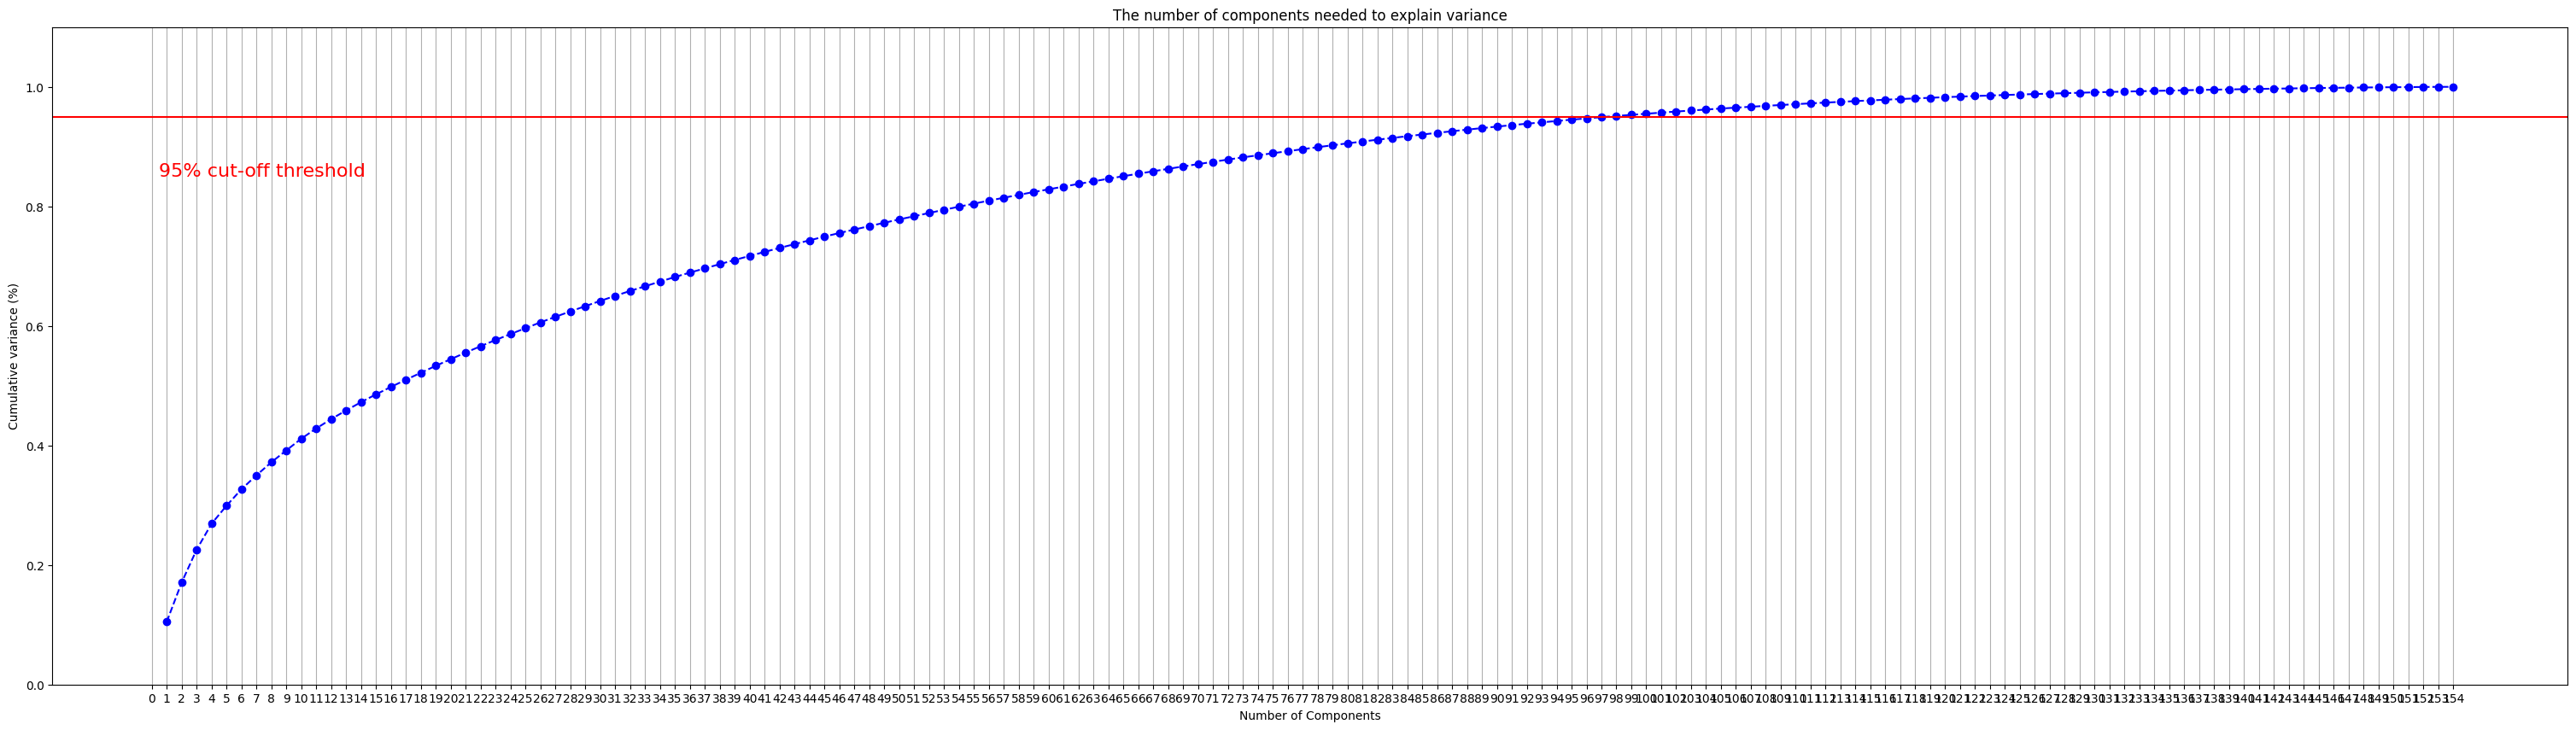

In [28]:
pca = PCA().fit(maldi_ss)

plt.rcParams["figure.figsize"] = (38,10)

fig, ax = plt.subplots()
xi = np.arange(1, 155, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 155, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [29]:
maldi_pca = dimensionality_reduction_cluster(maldi_ss,100)

(154, 306)
(154, 100)


In [30]:
df_animals = pd.concat([maldi_pca, animals_dummies], axis=1)
display(df_animals)

df_agg = pd.concat([maldi_pca, feat_agg_dummies], axis=1)
display(df_agg)

,0,1,2,3,4,5,6,7,8,9,...,Swine,Ovine,Goat,Hedgehog,Horse,Donkey,Wolf,Reference strain (CCUG),Water buffalo,Wild boar
V13,2.914505,-0.893505,4.930729,4.919713,-7.530538,6.292496,-6.566400,-1.839053,-2.617179,-5.802964,...,0,0,0,0,0,0,0,0,0,0
V142,7.330642,-7.536282,3.864134,5.122782,-3.206389,-4.463152,3.421845,1.120079,-6.276217,0.616768,...,0,0,0,0,0,0,0,0,0,0
V151,0.883078,-7.364645,6.141049,1.397811,-3.986082,0.483672,-2.452399,1.755711,-1.047740,1.290413,...,0,0,0,0,0,0,0,0,0,0
V160,1.957548,-6.185956,7.604279,-0.148070,-3.354730,-3.356464,-2.083378,5.112748,-2.011904,2.761969,...,0,0,0,0,0,0,0,0,0,0
V161,7.046195,-8.290956,2.398007,0.959701,-0.536526,0.418014,0.288453,0.850894,-2.479340,-0.674914,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,-3.828276,1.527860,-1.149222,2.286297,2.501838,-0.262096,-2.080199,-0.988223,2.372586,-1.984658,...,0,0,0,0,0,0,0,0,0,0
V82,5.759461,-7.847762,3.002862,2.157054,-1.918114,-3.639118,2.520195,1.823731,-1.552686,0.727494,...,0,0,0,0,0,0,0,0,0,0
V90,2.105216,-5.692917,6.195710,-1.951970,-1.380239,-0.424569,-2.089046,3.224552,0.193074,0.012244,...,0,0,0,0,0,0,0,0,0,0
V91,6.029059,-8.112475,3.249396,0.440623,-1.597500,-2.818253,1.200611,1.425323,-1.838054,0.514569,...,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,Animal species of origin_Hedgehog,Animal species of origin_Horse,Animal species of origin_Ovine,Animal species of origin_Reference strain (CCUG),Animal species of origin_Swine,Animal species of origin_Water buffalo,Animal species of origin_Wolf,Animal species of origin_Wild boar,Haemolysis_a,Haemolysis_b
V13,2.914505,-0.893505,4.930729,4.919713,-7.530538,6.292496,-6.566400,-1.839053,-2.617179,-5.802964,...,0,0,0,0,0,0,0,0,0,1
V142,7.330642,-7.536282,3.864134,5.122782,-3.206389,-4.463152,3.421845,1.120079,-6.276217,0.616768,...,0,0,0,0,0,0,0,0,0,1
V151,0.883078,-7.364645,6.141049,1.397811,-3.986082,0.483672,-2.452399,1.755711,-1.047740,1.290413,...,0,0,0,0,0,0,0,0,0,1
V160,1.957548,-6.185956,7.604279,-0.148070,-3.354730,-3.356464,-2.083378,5.112748,-2.011904,2.761969,...,0,0,0,0,0,0,0,0,0,1
V161,7.046195,-8.290956,2.398007,0.959701,-0.536526,0.418014,0.288453,0.850894,-2.479340,-0.674914,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,-3.828276,1.527860,-1.149222,2.286297,2.501838,-0.262096,-2.080199,-0.988223,2.372586,-1.984658,...,0,0,0,0,0,0,0,0,1,0
V82,5.759461,-7.847762,3.002862,2.157054,-1.918114,-3.639118,2.520195,1.823731,-1.552686,0.727494,...,0,0,0,0,0,0,0,0,0,1
V90,2.105216,-5.692917,6.195710,-1.951970,-1.380239,-0.424569,-2.089046,3.224552,0.193074,0.012244,...,0,0,0,0,0,0,0,0,0,1
V91,6.029059,-8.112475,3.249396,0.440623,-1.597500,-2.818253,1.200611,1.425323,-1.838054,0.514569,...,0,0,0,0,0,0,0,0,0,1


In [31]:
#Dataframe per confronto predizioni
pred_ensemble_cluster = {}

dfs_cluster = {'maldi' : maldi_pca,
       'animals' : df_animals,
       'agg' : df_agg}

model_obj_cluster = {}
#Dataframe con risultati metriche per ogni modello
metrics_df_cluster = pd.DataFrame(columns=['Target', 'Dataframe', 'Model', 'Accuracy', 'St. Dev.',
                            'Precision', 'Recall', 'F1-Score', 'Bal. Accuracy',
                            'Silhouette', 'Calinski', 'Davies'])
column = 'subspecies'
y = subspecies
display(y)
print("Colonna:"+column)
for str_df, X in dfs_cluster.items():
  print('Dataframe: '+str_df)
  pred_ensemble_cluster[str_df] = pd.DataFrame()
  display(X)
  #Scorre i modelli nel dizionario dei modelli utilizzati
  for name, model in models_cluster.items():
      print("Modello "+name)
      #model = clone(model_cluster)
      print(model.get_params())
      #Modello base: cross validation with score, fit, predict
      score_cluster = makeCrossValidationCluster(model, X)
      y_pred = model.fit_predict(X)
      y_pred = pd.DataFrame(y_pred,X.index, columns=['subspecies'])
      max = 0
      display(y_pred['subspecies'].values)
      for mapping in maps_cluster:
        print(mapping)
        y_pred_mapped = y_pred.iloc[:,0].map(mapping)
        score_mapped = makeScore(y, y_pred_mapped)
        if score_mapped['acc'] > max:
          max = score_mapped['acc']
          print(max)
          score = score_mapped
          y_pred_def = y_pred_mapped

      pred_ensemble_cluster[str_df][name] = y_pred_def

      ris = {'Target': column,
              'Dataframe' : str_df,
              'Model': name,
              'Accuracy' : score['acc'],
              'St. Dev.' : score['st'],
              'Precision' : score['prec'],
              'Recall' : score['rec'],
              'F1-Score' : score['f1'],
              'Bal. Accuracy' : score['b_acc'],
              'Silhouette' : score_cluster['Silhouette'],
              'Calinski' : score_cluster['Calinski'],
              'Davies' : score_cluster['Davies']}
      #display(ris)
      metrics_df_cluster = metrics_df_cluster.append(ris, ignore_index=True)
      model_obj_cluster[column+'_'+str_df+'_'+name] = model
      pickle.dump(model, open('models_obj/prova_cluster_'+str_df+'_'+name+'.pkl', 'wb'))

  #Aggiunge i valori del target nei dizionari
  pred_ensemble_cluster[str_df].index = maldi_pca.index
  pred_ensemble_cluster[str_df].to_csv('../Risultati/prediction/cluster_'+str_df+'_picchi'+str(n)+'.csv', index = True)
#metrics_df_cluster.to_csv('/content/drive/MyDrive/Progetti/StreptococcoClassification/results/cluster_train_picchi'+str(n)+'.csv', index = False)
display(metrics_df_cluster)
print("Modelli:")
print(model_obj_cluster)

,subspecies
ID Strain,
V13,2
V142,2
V151,2
V160,2
V161,2
...,...
V800,1
V82,2
V90,2


Colonna:subspecies
Dataframe: maldi


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
V13,2.914505,-0.893505,4.930729,4.919713,-7.530538,6.292496,-6.566400,-1.839053,-2.617179,-5.802964,...,-0.457213,-0.138786,-0.007876,0.060854,-0.314777,-0.054461,-0.137885,-0.246568,0.063930,0.136316
V142,7.330642,-7.536282,3.864134,5.122782,-3.206389,-4.463152,3.421845,1.120079,-6.276217,0.616768,...,-0.400910,-0.780609,-0.273754,-0.551037,0.523192,0.666535,0.295123,-0.300554,-0.179571,-0.558040
V151,0.883078,-7.364645,6.141049,1.397811,-3.986082,0.483672,-2.452399,1.755711,-1.047740,1.290413,...,0.316044,0.073364,-0.415966,0.157239,0.022831,0.065327,0.447354,-0.398533,-0.136819,-0.112904
V160,1.957548,-6.185956,7.604279,-0.148070,-3.354730,-3.356464,-2.083378,5.112748,-2.011904,2.761969,...,0.323514,0.024841,0.171615,0.401668,-0.271966,-0.003794,-0.788821,1.005835,0.403890,-0.660962
V161,7.046195,-8.290956,2.398007,0.959701,-0.536526,0.418014,0.288453,0.850894,-2.479340,-0.674914,...,-0.762499,-1.084503,-0.669741,0.743978,0.263057,-0.259976,0.435192,1.030174,-1.843589,0.076410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,-3.828276,1.527860,-1.149222,2.286297,2.501838,-0.262096,-2.080199,-0.988223,2.372586,-1.984658,...,-0.382612,0.544392,0.845249,1.993687,0.322431,-0.351927,-0.755432,0.148266,-1.077243,-0.446985
V82,5.759461,-7.847762,3.002862,2.157054,-1.918114,-3.639118,2.520195,1.823731,-1.552686,0.727494,...,-0.227438,1.239911,-0.481601,1.662408,0.426437,-1.368696,1.238647,-0.852460,0.038032,1.352335
V90,2.105216,-5.692917,6.195710,-1.951970,-1.380239,-0.424569,-2.089046,3.224552,0.193074,0.012244,...,-1.238630,-0.339794,-0.654741,-0.387039,0.410206,0.476699,-0.853738,-0.887025,-0.663893,-0.948807
V91,6.029059,-8.112475,3.249396,0.440623,-1.597500,-2.818253,1.200611,1.425323,-1.838054,0.514569,...,-0.852637,0.606904,-0.884880,0.634548,-0.244002,0.186460,-0.452250,-0.037399,0.246309,-0.174786


Modello K-means
{'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10, 'random_state': 46, 'tol': 0.0001, 'verbose': 0}


array([1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 2, 1, 0, 0,
       1, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0,
       1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 2,
       2, 0, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 2, 0, 2, 1, 2, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1,
       0, 2, 0, 0, 1, 2, 1, 2, 2, 2, 1, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2])

{2: 2, 1: 1, 0: 0}
{2: 2, 1: 0, 0: 1}
0.36363636363636365
{2: 1, 1: 0, 0: 2}
{2: 1, 1: 2, 0: 0}
{2: 0, 1: 2, 0: 1}
1.0
{2: 0, 1: 1, 0: 2}
Dataframe: animals


,0,1,2,3,4,5,6,7,8,9,...,Swine,Ovine,Goat,Hedgehog,Horse,Donkey,Wolf,Reference strain (CCUG),Water buffalo,Wild boar
V13,2.914505,-0.893505,4.930729,4.919713,-7.530538,6.292496,-6.566400,-1.839053,-2.617179,-5.802964,...,0,0,0,0,0,0,0,0,0,0
V142,7.330642,-7.536282,3.864134,5.122782,-3.206389,-4.463152,3.421845,1.120079,-6.276217,0.616768,...,0,0,0,0,0,0,0,0,0,0
V151,0.883078,-7.364645,6.141049,1.397811,-3.986082,0.483672,-2.452399,1.755711,-1.047740,1.290413,...,0,0,0,0,0,0,0,0,0,0
V160,1.957548,-6.185956,7.604279,-0.148070,-3.354730,-3.356464,-2.083378,5.112748,-2.011904,2.761969,...,0,0,0,0,0,0,0,0,0,0
V161,7.046195,-8.290956,2.398007,0.959701,-0.536526,0.418014,0.288453,0.850894,-2.479340,-0.674914,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,-3.828276,1.527860,-1.149222,2.286297,2.501838,-0.262096,-2.080199,-0.988223,2.372586,-1.984658,...,0,0,0,0,0,0,0,0,0,0
V82,5.759461,-7.847762,3.002862,2.157054,-1.918114,-3.639118,2.520195,1.823731,-1.552686,0.727494,...,0,0,0,0,0,0,0,0,0,0
V90,2.105216,-5.692917,6.195710,-1.951970,-1.380239,-0.424569,-2.089046,3.224552,0.193074,0.012244,...,0,0,0,0,0,0,0,0,0,0
V91,6.029059,-8.112475,3.249396,0.440623,-1.597500,-2.818253,1.200611,1.425323,-1.838054,0.514569,...,0,0,0,0,0,0,0,0,0,0


Modello K-means
{'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10, 'random_state': 46, 'tol': 0.0001, 'verbose': 0}


array([1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 2, 1, 0, 0,
       1, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0,
       1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 2,
       2, 0, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 2, 0, 2, 1, 2, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1,
       0, 2, 0, 0, 1, 2, 1, 2, 2, 2, 1, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2])

{2: 2, 1: 1, 0: 0}
{2: 2, 1: 0, 0: 1}
0.36363636363636365
{2: 1, 1: 0, 0: 2}
{2: 1, 1: 2, 0: 0}
{2: 0, 1: 2, 0: 1}
1.0
{2: 0, 1: 1, 0: 2}
Dataframe: agg


,0,1,2,3,4,5,6,7,8,9,...,Animal species of origin_Hedgehog,Animal species of origin_Horse,Animal species of origin_Ovine,Animal species of origin_Reference strain (CCUG),Animal species of origin_Swine,Animal species of origin_Water buffalo,Animal species of origin_Wolf,Animal species of origin_Wild boar,Haemolysis_a,Haemolysis_b
V13,2.914505,-0.893505,4.930729,4.919713,-7.530538,6.292496,-6.566400,-1.839053,-2.617179,-5.802964,...,0,0,0,0,0,0,0,0,0,1
V142,7.330642,-7.536282,3.864134,5.122782,-3.206389,-4.463152,3.421845,1.120079,-6.276217,0.616768,...,0,0,0,0,0,0,0,0,0,1
V151,0.883078,-7.364645,6.141049,1.397811,-3.986082,0.483672,-2.452399,1.755711,-1.047740,1.290413,...,0,0,0,0,0,0,0,0,0,1
V160,1.957548,-6.185956,7.604279,-0.148070,-3.354730,-3.356464,-2.083378,5.112748,-2.011904,2.761969,...,0,0,0,0,0,0,0,0,0,1
V161,7.046195,-8.290956,2.398007,0.959701,-0.536526,0.418014,0.288453,0.850894,-2.479340,-0.674914,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,-3.828276,1.527860,-1.149222,2.286297,2.501838,-0.262096,-2.080199,-0.988223,2.372586,-1.984658,...,0,0,0,0,0,0,0,0,1,0
V82,5.759461,-7.847762,3.002862,2.157054,-1.918114,-3.639118,2.520195,1.823731,-1.552686,0.727494,...,0,0,0,0,0,0,0,0,0,1
V90,2.105216,-5.692917,6.195710,-1.951970,-1.380239,-0.424569,-2.089046,3.224552,0.193074,0.012244,...,0,0,0,0,0,0,0,0,0,1
V91,6.029059,-8.112475,3.249396,0.440623,-1.597500,-2.818253,1.200611,1.425323,-1.838054,0.514569,...,0,0,0,0,0,0,0,0,0,1


Modello K-means
{'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10, 'random_state': 46, 'tol': 0.0001, 'verbose': 0}


array([1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 2, 1, 0, 0,
       1, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0,
       1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 2,
       2, 0, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 2, 0, 2, 1, 2, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1,
       0, 2, 0, 0, 1, 2, 1, 2, 2, 2, 1, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2])

{2: 2, 1: 1, 0: 0}
{2: 2, 1: 0, 0: 1}
0.36363636363636365
{2: 1, 1: 0, 0: 2}
{2: 1, 1: 2, 0: 0}
{2: 0, 1: 2, 0: 1}
1.0
{2: 0, 1: 1, 0: 2}


,Target,Dataframe,Model,Accuracy,St. Dev.,Precision,Recall,F1-Score,Bal. Accuracy,Silhouette,Calinski,Davies
0,subspecies,maldi,K-means,1.0,0.0,1.0,1.0,1.0,1.0,0.466926,169.679235,0.793615
1,subspecies,animals,K-means,1.0,0.0,1.0,1.0,1.0,1.0,0.474908,175.357390,0.779482
2,subspecies,agg,K-means,1.0,0.0,1.0,1.0,1.0,1.0,0.481401,179.905076,0.772582


Modelli:
{'subspecies_maldi_K-means': KMeans(n_clusters=3, random_state=46), 'subspecies_animals_K-means': KMeans(n_clusters=3, random_state=46), 'subspecies_agg_K-means': KMeans(n_clusters=3, random_state=46)}


In [32]:
clusters = {}
clusters_str = {}
clusters_dummies = {}
for dfs in dfs_cluster:
  clusters[dfs] = pred_ensemble_cluster[dfs]
  display(clusters[dfs])
  clusters_str[dfs] = clusters[dfs].applymap(map_target_inv.get)
  display(clusters_str[dfs])
  clusters_dummies[dfs] = pd.DataFrame.from_dict(pd.get_dummies(clusters_str[dfs]))
  display(clusters_dummies[dfs])

,K-means
V13,2
V142,2
V151,2
V160,2
V161,2
...,...
V800,1
V82,2
V90,2
V91,2


,K-means
V13,Canis
V142,Canis
V151,Canis
V160,Canis
V161,Canis
...,...
V800,Dysgalactiae
V82,Canis
V90,Canis
V91,Canis


,K-means_Canis,K-means_Dysgalactiae,K-means_Equisimilis
V13,1,0,0
V142,1,0,0
V151,1,0,0
V160,1,0,0
V161,1,0,0
...,...,...,...
V800,0,1,0
V82,1,0,0
V90,1,0,0
V91,1,0,0


,K-means
V13,2
V142,2
V151,2
V160,2
V161,2
...,...
V800,1
V82,2
V90,2
V91,2


,K-means
V13,Canis
V142,Canis
V151,Canis
V160,Canis
V161,Canis
...,...
V800,Dysgalactiae
V82,Canis
V90,Canis
V91,Canis


,K-means_Canis,K-means_Dysgalactiae,K-means_Equisimilis
V13,1,0,0
V142,1,0,0
V151,1,0,0
V160,1,0,0
V161,1,0,0
...,...,...,...
V800,0,1,0
V82,1,0,0
V90,1,0,0
V91,1,0,0


,K-means
V13,2
V142,2
V151,2
V160,2
V161,2
...,...
V800,1
V82,2
V90,2
V91,2


,K-means
V13,Canis
V142,Canis
V151,Canis
V160,Canis
V161,Canis
...,...
V800,Dysgalactiae
V82,Canis
V90,Canis
V91,Canis


,K-means_Canis,K-means_Dysgalactiae,K-means_Equisimilis
V13,1,0,0
V142,1,0,0
V151,1,0,0
V160,1,0,0
V161,1,0,0
...,...,...,...
V800,0,1,0
V82,1,0,0
V90,1,0,0
V91,1,0,0


In [33]:
df_clusters = pd.concat([maldi_pca, clusters_dummies['maldi']], axis=1)
display(df_clusters)

df_cluster_agg = pd.concat([df_agg, clusters_dummies['agg']], axis=1)
display(df_cluster_agg)

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,K-means_Canis,K-means_Dysgalactiae,K-means_Equisimilis
V13,2.914505,-0.893505,4.930729,4.919713,-7.530538,6.292496,-6.566400,-1.839053,-2.617179,-5.802964,...,0.060854,-0.314777,-0.054461,-0.137885,-0.246568,0.063930,0.136316,1,0,0
V142,7.330642,-7.536282,3.864134,5.122782,-3.206389,-4.463152,3.421845,1.120079,-6.276217,0.616768,...,-0.551037,0.523192,0.666535,0.295123,-0.300554,-0.179571,-0.558040,1,0,0
V151,0.883078,-7.364645,6.141049,1.397811,-3.986082,0.483672,-2.452399,1.755711,-1.047740,1.290413,...,0.157239,0.022831,0.065327,0.447354,-0.398533,-0.136819,-0.112904,1,0,0
V160,1.957548,-6.185956,7.604279,-0.148070,-3.354730,-3.356464,-2.083378,5.112748,-2.011904,2.761969,...,0.401668,-0.271966,-0.003794,-0.788821,1.005835,0.403890,-0.660962,1,0,0
V161,7.046195,-8.290956,2.398007,0.959701,-0.536526,0.418014,0.288453,0.850894,-2.479340,-0.674914,...,0.743978,0.263057,-0.259976,0.435192,1.030174,-1.843589,0.076410,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,-3.828276,1.527860,-1.149222,2.286297,2.501838,-0.262096,-2.080199,-0.988223,2.372586,-1.984658,...,1.993687,0.322431,-0.351927,-0.755432,0.148266,-1.077243,-0.446985,0,1,0
V82,5.759461,-7.847762,3.002862,2.157054,-1.918114,-3.639118,2.520195,1.823731,-1.552686,0.727494,...,1.662408,0.426437,-1.368696,1.238647,-0.852460,0.038032,1.352335,1,0,0
V90,2.105216,-5.692917,6.195710,-1.951970,-1.380239,-0.424569,-2.089046,3.224552,0.193074,0.012244,...,-0.387039,0.410206,0.476699,-0.853738,-0.887025,-0.663893,-0.948807,1,0,0
V91,6.029059,-8.112475,3.249396,0.440623,-1.597500,-2.818253,1.200611,1.425323,-1.838054,0.514569,...,0.634548,-0.244002,0.186460,-0.452250,-0.037399,0.246309,-0.174786,1,0,0


,0,1,2,3,4,5,6,7,8,9,...,Animal species of origin_Reference strain (CCUG),Animal species of origin_Swine,Animal species of origin_Water buffalo,Animal species of origin_Wolf,Animal species of origin_Wild boar,Haemolysis_a,Haemolysis_b,K-means_Canis,K-means_Dysgalactiae,K-means_Equisimilis
V13,2.914505,-0.893505,4.930729,4.919713,-7.530538,6.292496,-6.566400,-1.839053,-2.617179,-5.802964,...,0,0,0,0,0,0,1,1,0,0
V142,7.330642,-7.536282,3.864134,5.122782,-3.206389,-4.463152,3.421845,1.120079,-6.276217,0.616768,...,0,0,0,0,0,0,1,1,0,0
V151,0.883078,-7.364645,6.141049,1.397811,-3.986082,0.483672,-2.452399,1.755711,-1.047740,1.290413,...,0,0,0,0,0,0,1,1,0,0
V160,1.957548,-6.185956,7.604279,-0.148070,-3.354730,-3.356464,-2.083378,5.112748,-2.011904,2.761969,...,0,0,0,0,0,0,1,1,0,0
V161,7.046195,-8.290956,2.398007,0.959701,-0.536526,0.418014,0.288453,0.850894,-2.479340,-0.674914,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,-3.828276,1.527860,-1.149222,2.286297,2.501838,-0.262096,-2.080199,-0.988223,2.372586,-1.984658,...,0,0,0,0,0,1,0,0,1,0
V82,5.759461,-7.847762,3.002862,2.157054,-1.918114,-3.639118,2.520195,1.823731,-1.552686,0.727494,...,0,0,0,0,0,0,1,1,0,0
V90,2.105216,-5.692917,6.195710,-1.951970,-1.380239,-0.424569,-2.089046,3.224552,0.193074,0.012244,...,0,0,0,0,0,0,1,1,0,0
V91,6.029059,-8.112475,3.249396,0.440623,-1.597500,-2.818253,1.200611,1.425323,-1.838054,0.514569,...,0,0,0,0,0,0,1,1,0,0


In [34]:
#Dataframe per confronto predizioni
score_target = {}
pred_ensemble = pd.DataFrame()
pred_ensemble_best = pd.DataFrame()
pred_ensemble_pca = pd.DataFrame()
pred_ensemble_best_pca = pd.DataFrame()

dfs = {'maldi' : maldi_pca,
       'clusters' : df_clusters,
       #'animals' : df_animals,
       'agg' : df_agg,
       'clusters+agg' : df_cluster_agg}

model_obj = {}
#Dataframe con risultati metriche per ogni modello
metrics_df = pd.DataFrame(columns=['Target', 'Dataframe', 'Model', 'Accuracy CV', 'St. Dev. CV',
                            'Precision CV', 'Recall CV','F1-Score CV','Accuracy','Bal. Accuracy'])
#Per ogni tipologia di target del problema (sottospecie, antibiotici, geni, fattori, st)
for str_target, target in targets.items():
  columns = target.columns
  #Per ogni tipologia di target scorre tutti i target
  for column in columns:
    print("Colonna:"+column)
    y = target[column]
    for str_df, X in dfs.items():
      print('Dataframe: '+str_df)

      #Lista dei modelli con tuning degli iperparametri
      models_best = list()
      models_best_pca = list()

      #parameter range for BernoulliNB in base of the number of classes in the target
      n_classes = np.unique(y)
      param_grid['BernoulliNB']['class_prior'] = [None, [0.1,]* len(n_classes)]

      # split the data into training and testing sets
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

      #Modello di stacking della libreria mlxtend
      '''stack = StackingCVClassifier(classifiers = list(models.values()),
                                  shuffle = False,
                                  use_probas = False,
                                  cv = 5,
                                  meta_classifier = models['SVC'])

      models['stack'] = stack'''

      #Scorre i modelli nel dizionario dei modelli utilizzati
      for name, model in models.items():
          #print("Modello "+name)
          model_base = model
          model_best = model

          #Modello base: cross validation with score, fit, predict
          score_cv = makeCrossValidation(model_base, X_train, y_train)
          model_base.fit(X_train, y_train)
          y_pred = model_base.predict(X_test)

          score = makeScore(y_test, y_pred)
          pred_ensemble[name] = y_pred

          ris = {'Target': column,
                  'Dataframe' : str_df,
                  'Model': name,
                  'Accuracy CV' : score_cv['acc'],
                  'St. Dev. CV' : score_cv['st'],
                  'Precision CV' : score_cv['prec'],
                  'Recall CV' : score_cv['rec'],
                  'F1-Score CV' : score_cv['f1'],
                  'Accuracy' : score['acc'],
                  'Bal. Accuracy' : score['b_acc']}

          #display(ris)
          metrics_df = metrics_df.append(ris, ignore_index=True)
          model_obj[str_target+'_'+column+'_'+str_df+'_'+name] = model_base

          #TUNING MODEL
          model_best, score_cv = makeTuning(model_best, X_train, y_train, name)
          models_best.append((name,model_best))
          model_best.fit(X_train, y_train)
          y_pred = model_best.predict(X_test)

          score = makeScore(y_test, y_pred)
          pred_ensemble_best[name] = y_pred

          ris = {'Target': column,
                  'Dataframe' : str_df,
                  'Model': name+'_Best',
                  'Accuracy CV' : score_cv['acc'],
                  'St. Dev. CV' : score_cv['st'],
                  'Precision CV' : score_cv['prec'],
                  'Recall CV' : score_cv['rec'],
                  'F1-Score CV' : score_cv['f1'],
                  'Accuracy' : score['acc'],
                  'Bal. Accuracy' : score['b_acc']}
          #display(ris)
          metrics_df = metrics_df.append(ris, ignore_index=True)
          model_obj[str_target+'_'+column+'_'+str_df+'_'+name+'_Best'] = model_best

  #Aggiunge i valori del target nei dizionari
  pred_ensemble['Target'] = y_test.values
  pred_ensemble_best['Target'] = y_test.values

  #Stampa le predizioni
  '''display(pred_ensemble)
  print("Model with tuning")
  display(pred_ensemble_best)'''

display(metrics_df)
print("Modelli:")
print(model_obj)

Colonna:mf3
Dataframe: maldi
Dataframe: clusters
Dataframe: agg
Dataframe: clusters+agg
Colonna:subspecies
Dataframe: maldi
Dataframe: clusters
Dataframe: agg
Dataframe: clusters+agg


,Target,Dataframe,Model,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
0,mf3,maldi,LogisticRegression,0.730667,0.095885,0.731675,0.730667,0.722409,0.741935,0.697727
1,mf3,maldi,LogisticRegression_Best,0.722333,0.146210,0.754153,0.722333,0.725030,0.741935,0.738636
2,mf3,maldi,Ridge,0.658000,0.072153,0.671873,0.658000,0.658776,0.548387,0.568182
3,mf3,maldi,Ridge_Best,0.698333,0.102751,0.699149,0.698333,0.694060,0.645161,0.602273
4,mf3,maldi,DecisionTree,0.650333,0.049288,0.657515,0.650333,0.651393,0.612903,0.556818
...,...,...,...,...,...,...,...,...,...,...
171,subspecies,clusters+agg,LabelPropagation_Best,0.967333,0.016350,0.971365,0.967333,0.967343,1.000000,1.000000
172,subspecies,clusters+agg,LabelSpreading,0.276333,0.013920,0.076554,0.276333,0.119844,0.387097,0.375000
173,subspecies,clusters+agg,LabelSpreading_Best,0.967333,0.016350,0.971365,0.967333,0.967343,1.000000,1.000000
174,subspecies,clusters+agg,SGDClassifier,0.967667,0.016180,0.971657,0.967667,0.967780,1.000000,1.000000


Modelli:
{'virulenza_mf3_maldi_LogisticRegression': LogisticRegression(random_state=46), 'virulenza_mf3_maldi_LogisticRegression_Best': LogisticRegression(C=0.00046415888336127773, class_weight='balanced',
                   intercept_scaling=2, penalty='none', random_state=46,
                   solver='sag'), 'virulenza_mf3_maldi_Ridge': RidgeClassifier(random_state=46), 'virulenza_mf3_maldi_Ridge_Best': RidgeClassifier(alpha=16.451905877536642, random_state=46), 'virulenza_mf3_maldi_DecisionTree': DecisionTreeClassifier(random_state=46), 'virulenza_mf3_maldi_DecisionTree_Best': DecisionTreeClassifier(ccp_alpha=0.31622776601683794, criterion='log_loss',
                       max_depth=3, max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, random_state=46), 'virulenza_mf3_maldi_K-nn': KNeighborsClassifier(), 'virulenza_mf3_maldi_K-nn_Best': KNeighborsClassifier(n_neighbors=8, weights='distance'), 'virulenza_mf3_maldi_RandomForest': RandomForestClassif

In [40]:
#Per ogni target prende il migliore in base alla metrica utilizzata,
#una volta che un modello è stato selezionato come migliore per un target data una specifica metrica,
#viene rimosso in modo che non si ripeta lo stesso modello per tutte le metriche
metriche = ['Accuracy', 'Accuracy CV', 'Bal. Accuracy', 'F1-Score CV']
best_models = {}

for str_df, X in dfs.items():
  best_models[str_df] = {}
  for str_target, target in targets.items():
    columns = target.columns
    for column in columns:
      filter = metrics_df["Target"]==column
      filter_df = metrics_df["Dataframe"]==str_df
      print(column)
      print(str_df)
      # filtering data
      subs_df = metrics_df.where(filter & filter_df, inplace = False).dropna()
      list_models = []
      display(subs_df)
      for metric in metriche:
        #Prende l'id del modello con valore massimo per lo speficico target e metrica
        id = subs_df[metric].idxmax()
        model = subs_df.loc[id,'Model']
        max = subs_df[metric].max()
        list_models.append(str_target+'_'+column+'_'+str_df+'_'+model)
        subs_df.drop(id, inplace = True)

        print(column+' : '+str_df+' : '+model+' : '+metric+' : '+str(max))
      best_models[str_df][column] = list_models
display(best_models)

mf3
maldi


,Target,Dataframe,Model,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
0,mf3,maldi,LogisticRegression,0.730667,0.095885,0.731675,0.730667,0.722409,0.741935,0.697727
1,mf3,maldi,LogisticRegression_Best,0.722333,0.146210,0.754153,0.722333,0.725030,0.741935,0.738636
2,mf3,maldi,Ridge,0.658000,0.072153,0.671873,0.658000,0.658776,0.548387,0.568182
3,mf3,maldi,Ridge_Best,0.698333,0.102751,0.699149,0.698333,0.694060,0.645161,0.602273
4,mf3,maldi,DecisionTree,0.650333,0.049288,0.657515,0.650333,0.651393,0.612903,0.556818
5,mf3,maldi,DecisionTree_Best,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000
6,mf3,maldi,K-nn,0.698333,0.105820,0.679833,0.698333,0.652556,0.612903,0.495455
7,mf3,maldi,K-nn_Best,0.756333,0.068511,0.777678,0.756333,0.715051,0.645161,0.540909
8,mf3,maldi,RandomForest,0.683333,0.035637,0.611830,0.683333,0.605590,0.677419,0.545455
9,mf3,maldi,RandomForest_Best,0.699667,0.063739,0.689902,0.699667,0.645680,0.645161,0.561364


mf3 : maldi : LogisticRegression : Accuracy : 0.7419354838709677
mf3 : maldi : K-nn_Best : Accuracy CV : 0.7563333333333333
mf3 : maldi : LogisticRegression_Best : Bal. Accuracy : 0.7386363636363636
mf3 : maldi : BernoulliNB_Best : F1-Score CV : 0.7016670884670885
subspecies
maldi


,Target,Dataframe,Model,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
88,subspecies,maldi,LogisticRegression,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
89,subspecies,maldi,LogisticRegression_Best,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
90,subspecies,maldi,Ridge,0.911000,0.046207,0.923075,0.911000,0.911288,0.903226,0.909091
91,subspecies,maldi,Ridge_Best,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
92,subspecies,maldi,DecisionTree,0.935000,0.049193,0.938000,0.935000,0.934678,0.935484,0.916667
93,subspecies,maldi,DecisionTree_Best,0.691333,0.039078,0.536009,0.691333,0.590958,0.645161,0.666667
94,subspecies,maldi,K-nn,0.984000,0.019596,0.985600,0.984000,0.983806,0.967742,0.969697
95,subspecies,maldi,K-nn_Best,0.984000,0.019596,0.985600,0.984000,0.983806,0.967742,0.969697
96,subspecies,maldi,RandomForest,0.943667,0.031840,0.953227,0.943667,0.941907,0.903226,0.897727
97,subspecies,maldi,RandomForest_Best,0.959667,0.043823,0.962300,0.959667,0.959504,0.935484,0.916667


subspecies : maldi : LogisticRegression : Accuracy : 1.0
subspecies : maldi : LogisticRegression_Best : Accuracy CV : 1.0
subspecies : maldi : Ridge_Best : Bal. Accuracy : 1.0
subspecies : maldi : GaussianNB_Best : F1-Score CV : 1.0
mf3
clusters


,Target,Dataframe,Model,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
22,mf3,clusters,LogisticRegression,0.730667,0.095885,0.731675,0.730667,0.722409,0.741935,0.697727
23,mf3,clusters,LogisticRegression_Best,0.730667,0.123835,0.757058,0.730667,0.733158,0.709677,0.693182
24,mf3,clusters,Ridge,0.658000,0.072153,0.671873,0.658000,0.658776,0.516129,0.543182
25,mf3,clusters,Ridge_Best,0.698333,0.102751,0.699149,0.698333,0.694060,0.645161,0.602273
26,mf3,clusters,DecisionTree,0.641333,0.059809,0.650747,0.641333,0.644411,0.580645,0.552273
27,mf3,clusters,DecisionTree_Best,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000
28,mf3,clusters,K-nn,0.698333,0.105820,0.679833,0.698333,0.652556,0.612903,0.495455
29,mf3,clusters,K-nn_Best,0.748000,0.080411,0.768906,0.748000,0.708685,0.645161,0.540909
30,mf3,clusters,RandomForest,0.708000,0.050104,0.651946,0.708000,0.624751,0.677419,0.545455
31,mf3,clusters,RandomForest_Best,0.707333,0.054697,0.672558,0.707333,0.640370,0.612903,0.515909


mf3 : clusters : BernoulliNB : Accuracy : 0.7741935483870968
mf3 : clusters : K-nn_Best : Accuracy CV : 0.748
mf3 : clusters : SGDClassifier_Best : Bal. Accuracy : 0.7636363636363637
mf3 : clusters : LogisticRegression_Best : F1-Score CV : 0.7331584836593326
subspecies
clusters


,Target,Dataframe,Model,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
110,subspecies,clusters,LogisticRegression,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
111,subspecies,clusters,LogisticRegression_Best,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
112,subspecies,clusters,Ridge,0.936000,0.064992,0.946200,0.936000,0.936314,0.935484,0.939394
113,subspecies,clusters,Ridge_Best,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
114,subspecies,clusters,DecisionTree,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
115,subspecies,clusters,DecisionTree_Best,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
116,subspecies,clusters,K-nn,0.984000,0.019596,0.985600,0.984000,0.983806,0.967742,0.969697
117,subspecies,clusters,K-nn_Best,0.984000,0.019596,0.985800,0.984000,0.983934,0.967742,0.969697
118,subspecies,clusters,RandomForest,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
119,subspecies,clusters,RandomForest_Best,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


subspecies : clusters : LogisticRegression : Accuracy : 1.0
subspecies : clusters : LogisticRegression_Best : Accuracy CV : 1.0
subspecies : clusters : Ridge_Best : Bal. Accuracy : 1.0
subspecies : clusters : DecisionTree : F1-Score CV : 1.0
mf3
agg


,Target,Dataframe,Model,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
44,mf3,agg,LogisticRegression,0.730667,0.095885,0.731675,0.730667,0.722409,0.741935,0.697727
45,mf3,agg,LogisticRegression_Best,0.746333,0.126861,0.757563,0.746333,0.747853,0.741935,0.697727
46,mf3,agg,Ridge,0.641667,0.051034,0.651095,0.641667,0.640679,0.548387,0.527273
47,mf3,agg,Ridge_Best,0.698333,0.102751,0.699149,0.698333,0.694060,0.645161,0.602273
48,mf3,agg,DecisionTree,0.658000,0.064372,0.667882,0.658000,0.662104,0.548387,0.486364
49,mf3,agg,DecisionTree_Best,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000
50,mf3,agg,K-nn,0.706333,0.111537,0.688214,0.706333,0.663036,0.612903,0.495455
51,mf3,agg,K-nn_Best,0.748000,0.080411,0.768906,0.748000,0.708685,0.645161,0.540909
52,mf3,agg,RandomForest,0.707667,0.045651,0.601985,0.707667,0.603290,0.677419,0.545455
53,mf3,agg,RandomForest_Best,0.690667,0.068228,0.668050,0.690667,0.625560,0.709677,0.590909


mf3 : agg : LogisticRegression : Accuracy : 0.7419354838709677
mf3 : agg : K-nn_Best : Accuracy CV : 0.748
mf3 : agg : LinearSVC : Bal. Accuracy : 0.7181818181818183
mf3 : agg : LogisticRegression_Best : F1-Score CV : 0.7478528138528138
subspecies
agg


,Target,Dataframe,Model,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
132,subspecies,agg,LogisticRegression,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
133,subspecies,agg,LogisticRegression_Best,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
134,subspecies,agg,Ridge,0.919333,0.056584,0.933700,0.919333,0.919796,0.903226,0.909091
135,subspecies,agg,Ridge_Best,1.000000,0.000000,1.000000,1.000000,1.000000,0.967742,0.969697
136,subspecies,agg,DecisionTree,0.927000,0.047707,0.930600,0.927000,0.925735,0.935484,0.916667
137,subspecies,agg,DecisionTree_Best,0.886667,0.038830,0.914505,0.886667,0.878848,0.935484,0.939394
138,subspecies,agg,K-nn,0.984000,0.019596,0.985600,0.984000,0.983806,0.967742,0.969697
139,subspecies,agg,K-nn_Best,0.984000,0.019596,0.985600,0.984000,0.983806,0.967742,0.969697
140,subspecies,agg,RandomForest,0.984000,0.019596,0.985600,0.984000,0.983806,0.903226,0.909091
141,subspecies,agg,RandomForest_Best,0.959667,0.035783,0.962100,0.959667,0.958595,1.000000,1.000000


subspecies : agg : LogisticRegression : Accuracy : 1.0
subspecies : agg : LogisticRegression_Best : Accuracy CV : 1.0
subspecies : agg : RandomForest_Best : Bal. Accuracy : 1.0
subspecies : agg : Ridge_Best : F1-Score CV : 1.0
mf3
clusters+agg


,Target,Dataframe,Model,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
66,mf3,clusters+agg,LogisticRegression,0.730667,0.095885,0.731675,0.730667,0.722409,0.741935,0.697727
67,mf3,clusters+agg,LogisticRegression_Best,0.746333,0.126861,0.757563,0.746333,0.747853,0.741935,0.697727
68,mf3,clusters+agg,Ridge,0.641667,0.051034,0.651095,0.641667,0.640679,0.548387,0.527273
69,mf3,clusters+agg,Ridge_Best,0.698333,0.102751,0.699149,0.698333,0.694060,0.645161,0.602273
70,mf3,clusters+agg,DecisionTree,0.641333,0.047357,0.669691,0.641333,0.650000,0.548387,0.506818
71,mf3,clusters+agg,DecisionTree_Best,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000
72,mf3,clusters+agg,K-nn,0.706333,0.111537,0.688214,0.706333,0.663036,0.612903,0.495455
73,mf3,clusters+agg,K-nn_Best,0.748000,0.080411,0.768906,0.748000,0.708685,0.645161,0.540909
74,mf3,clusters+agg,RandomForest,0.699333,0.031013,0.612597,0.699333,0.608224,0.645161,0.500000
75,mf3,clusters+agg,RandomForest_Best,0.683000,0.013679,0.466676,0.683000,0.554432,0.645161,0.500000


mf3 : clusters+agg : LogisticRegression : Accuracy : 0.7419354838709677
mf3 : clusters+agg : K-nn_Best : Accuracy CV : 0.748
mf3 : clusters+agg : LinearSVC : Bal. Accuracy : 0.7181818181818183
mf3 : clusters+agg : LogisticRegression_Best : F1-Score CV : 0.7478528138528138
subspecies
clusters+agg


,Target,Dataframe,Model,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
154,subspecies,clusters+agg,LogisticRegression,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
155,subspecies,clusters+agg,LogisticRegression_Best,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
156,subspecies,clusters+agg,Ridge,0.935667,0.054115,0.945857,0.935667,0.935466,0.967742,0.969697
157,subspecies,clusters+agg,Ridge_Best,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
158,subspecies,clusters+agg,DecisionTree,0.992000,0.016000,0.992800,0.992000,0.991903,1.000000,1.000000
159,subspecies,clusters+agg,DecisionTree_Best,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
160,subspecies,clusters+agg,K-nn,0.984000,0.019596,0.985600,0.984000,0.983806,0.967742,0.969697
161,subspecies,clusters+agg,K-nn_Best,0.984000,0.019596,0.985600,0.984000,0.983806,0.967742,0.969697
162,subspecies,clusters+agg,RandomForest,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
163,subspecies,clusters+agg,RandomForest_Best,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


subspecies : clusters+agg : LogisticRegression : Accuracy : 1.0
subspecies : clusters+agg : LogisticRegression_Best : Accuracy CV : 1.0
subspecies : clusters+agg : Ridge_Best : Bal. Accuracy : 1.0
subspecies : clusters+agg : DecisionTree_Best : F1-Score CV : 1.0


{'maldi': {'mf3': ['virulenza_mf3_maldi_LogisticRegression',
   'virulenza_mf3_maldi_K-nn_Best',
   'virulenza_mf3_maldi_LogisticRegression_Best',
   'virulenza_mf3_maldi_BernoulliNB_Best'],
  'subspecies': ['subspecies_subspecies_maldi_LogisticRegression',
   'subspecies_subspecies_maldi_LogisticRegression_Best',
   'subspecies_subspecies_maldi_Ridge_Best',
   'subspecies_subspecies_maldi_GaussianNB_Best']},
 'clusters': {'mf3': ['virulenza_mf3_clusters_BernoulliNB',
   'virulenza_mf3_clusters_K-nn_Best',
   'virulenza_mf3_clusters_SGDClassifier_Best',
   'virulenza_mf3_clusters_LogisticRegression_Best'],
  'subspecies': ['subspecies_subspecies_clusters_LogisticRegression',
   'subspecies_subspecies_clusters_LogisticRegression_Best',
   'subspecies_subspecies_clusters_Ridge_Best',
   'subspecies_subspecies_clusters_DecisionTree']},
 'agg': {'mf3': ['virulenza_mf3_agg_LogisticRegression',
   'virulenza_mf3_agg_K-nn_Best',
   'virulenza_mf3_agg_LinearSVC',
   'virulenza_mf3_agg_Logistic

In [41]:
metrics_stack = pd.DataFrame(columns=['Target', 'Dataframe', 'Model', 'Accuracy CV', 'St. Dev. CV',
                            'Precision CV', 'Recall CV','F1-Score CV','Accuracy','Bal. Accuracy'])

final_models = {}
for df_best,targets_best in best_models.items():
  #display(targets_best)
  for str_target,list_models in targets_best.items():
    print(str_target)
    print(list_models)
    stack_models = list()
    for str_model in list_models:
      model = model_obj[str_model]
      #print(model)
      stack_models.append((str_model, clone(model)))

    final_model = LogisticRegression()
    stack = StackingClassifier(estimators=stack_models, final_estimator=final_model)
    model_base = stack
    model_best = stack

    s = str_model.split('_')
    print(s)
    trg = targets[s[0]]
    y = trg.loc[:,s[1]]
    X = dfs[df_best]
    #display(X)
    #display(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    model_base.fit(X_train, y_train)
    final_models[str_model] = model_base
    y_pred = model_base.predict(X_test)

    #Modello base: cross validation with score, fit, predict
    score_cv = makeCrossValidation(model_base, X_train, y_train)
    score = makeScore(y_test, y_pred)

    ris = {'Target': str_target,
          'Dataframe' : df_best,
          'Model': 'Stack',
          'Accuracy CV' : score_cv['acc'],
          'St. Dev. CV' : score_cv['st'],
          'Precision CV' : score_cv['prec'],
          'Recall CV' : score_cv['rec'],
          'F1-Score CV' : score_cv['f1'],
          'Accuracy' : score['acc'],
          'Bal. Accuracy' : score['b_acc']}

    #display(ris)
    metrics_stack = metrics_stack.append(ris, ignore_index=True)
    print(s[1]+'_'+df_best+'_Stack')
    display(X_train)
    pickle.dump(model_base, open('models_obj/prova_'+s[1]+'_'+df_best+'_Stack.pkl', 'wb'))
    #Tuning iperparametri
    '''model_best, score_cv = makeTuning(model_best, X_train, y_train, 'stack')

    model_best.fit(X_train, y_train)
    y_pred = model_best.predict(X_test)

    score = makeScore(y_test, y_pred)

    ris = {'Target': str_target,
          'Dataframe' : df_best,
          'Riduzione' : pca,
          'Model': 'Stack_Best',
          'Accuracy CV' : score_cv['acc'],
          'St. Dev. CV' : score_cv['st'],
          'Precision CV' : score_cv['prec'],
          'Recall CV' : score_cv['rec'],
          'F1-Score CV' : score_cv['f1'],
          'Accuracy' : score['acc'],
          'Bal. Accuracy' : score['b_acc']}
    #display(ris)
    metrics_stack = metrics_stack.append(ris, ignore_index=True)'''

print('\n')
metrics_stack.to_csv('../Risultati/results/stack_train_picchi'+str(n)+'.csv', index = False)
display(metrics_stack)
display(final_models)

mf3
['virulenza_mf3_maldi_LogisticRegression', 'virulenza_mf3_maldi_K-nn_Best', 'virulenza_mf3_maldi_LogisticRegression_Best', 'virulenza_mf3_maldi_BernoulliNB_Best']
['virulenza', 'mf3', 'maldi', 'BernoulliNB', 'Best']
mf3_maldi_Stack


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
V306,-1.883071,1.854889,1.404285,-1.189866,-3.504305,-2.915300,-0.052559,0.731606,2.997172,-0.914593,...,0.771429,0.172685,-0.815413,-0.777271,-0.150972,2.837527,-0.501332,-0.284043,-0.680348,1.413647
V658,0.235041,7.383244,4.523342,2.648925,1.104098,-4.766347,-6.183794,-5.131975,4.117568,2.415641,...,0.182400,-0.563705,-0.557449,-0.114455,0.143064,-0.309464,-0.946792,-1.542727,0.346024,0.093327
V293,0.245782,3.666937,3.483395,0.391410,-2.664291,4.649901,-0.003861,-0.618927,3.111403,2.662576,...,-1.454644,1.429318,-1.367007,-1.093107,-0.598513,-1.445267,-0.499979,1.433321,0.069119,0.468740
V635,4.346248,9.748055,0.142624,8.093973,3.904149,-5.237018,-1.875187,3.895125,3.814993,-7.097566,...,0.674000,0.325457,1.012308,-0.612248,0.710046,-0.587492,-0.368368,0.013506,0.010842,0.149012
V531,6.516283,1.129490,-2.497223,-2.612558,-3.226493,1.537636,-4.111586,0.921697,0.206667,-2.690746,...,-1.690960,0.312648,0.620346,0.289179,-0.852347,-0.148994,1.407055,-1.391054,0.804302,-0.254694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V790,2.568819,9.765181,4.512641,-2.160023,-0.173208,4.000935,2.318849,1.271044,-4.003689,-2.717313,...,0.371356,0.942854,-0.332361,-0.388178,0.419090,0.626385,-0.074320,-0.303696,-0.001193,-0.196651
V794,0.094169,4.074889,3.430642,-2.687819,-2.714576,-1.401150,-1.455642,0.383684,4.209790,-0.172851,...,0.621015,-0.061559,0.264776,0.854683,0.683324,0.419148,0.950818,-0.827805,-0.050856,-0.859553
V704,6.407462,-2.017445,-0.459183,-0.467103,1.967874,-2.115376,-6.825098,-2.572682,-0.603359,-2.081875,...,0.219219,-0.973361,0.374597,-0.254641,0.407594,-0.075105,0.217725,-0.392082,0.352699,-1.217804
V291,5.815680,-6.122575,-1.411663,7.214279,5.152232,1.211157,5.632796,-2.514220,6.496699,-0.619027,...,0.516897,-0.508631,-0.174057,0.293477,-0.750991,0.435606,-0.054825,-0.091595,1.190676,0.562241


subspecies
['subspecies_subspecies_maldi_LogisticRegression', 'subspecies_subspecies_maldi_LogisticRegression_Best', 'subspecies_subspecies_maldi_Ridge_Best', 'subspecies_subspecies_maldi_GaussianNB_Best']
['subspecies', 'subspecies', 'maldi', 'GaussianNB', 'Best']
subspecies_maldi_Stack


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
V306,-1.883071,1.854889,1.404285,-1.189866,-3.504305,-2.915300,-0.052559,0.731606,2.997172,-0.914593,...,0.771429,0.172685,-0.815413,-0.777271,-0.150972,2.837527,-0.501332,-0.284043,-0.680348,1.413647
V658,0.235041,7.383244,4.523342,2.648925,1.104098,-4.766347,-6.183794,-5.131975,4.117568,2.415641,...,0.182400,-0.563705,-0.557449,-0.114455,0.143064,-0.309464,-0.946792,-1.542727,0.346024,0.093327
V293,0.245782,3.666937,3.483395,0.391410,-2.664291,4.649901,-0.003861,-0.618927,3.111403,2.662576,...,-1.454644,1.429318,-1.367007,-1.093107,-0.598513,-1.445267,-0.499979,1.433321,0.069119,0.468740
V635,4.346248,9.748055,0.142624,8.093973,3.904149,-5.237018,-1.875187,3.895125,3.814993,-7.097566,...,0.674000,0.325457,1.012308,-0.612248,0.710046,-0.587492,-0.368368,0.013506,0.010842,0.149012
V531,6.516283,1.129490,-2.497223,-2.612558,-3.226493,1.537636,-4.111586,0.921697,0.206667,-2.690746,...,-1.690960,0.312648,0.620346,0.289179,-0.852347,-0.148994,1.407055,-1.391054,0.804302,-0.254694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V790,2.568819,9.765181,4.512641,-2.160023,-0.173208,4.000935,2.318849,1.271044,-4.003689,-2.717313,...,0.371356,0.942854,-0.332361,-0.388178,0.419090,0.626385,-0.074320,-0.303696,-0.001193,-0.196651
V794,0.094169,4.074889,3.430642,-2.687819,-2.714576,-1.401150,-1.455642,0.383684,4.209790,-0.172851,...,0.621015,-0.061559,0.264776,0.854683,0.683324,0.419148,0.950818,-0.827805,-0.050856,-0.859553
V704,6.407462,-2.017445,-0.459183,-0.467103,1.967874,-2.115376,-6.825098,-2.572682,-0.603359,-2.081875,...,0.219219,-0.973361,0.374597,-0.254641,0.407594,-0.075105,0.217725,-0.392082,0.352699,-1.217804
V291,5.815680,-6.122575,-1.411663,7.214279,5.152232,1.211157,5.632796,-2.514220,6.496699,-0.619027,...,0.516897,-0.508631,-0.174057,0.293477,-0.750991,0.435606,-0.054825,-0.091595,1.190676,0.562241


mf3
['virulenza_mf3_clusters_BernoulliNB', 'virulenza_mf3_clusters_K-nn_Best', 'virulenza_mf3_clusters_SGDClassifier_Best', 'virulenza_mf3_clusters_LogisticRegression_Best']
['virulenza', 'mf3', 'clusters', 'LogisticRegression', 'Best']
mf3_clusters_Stack


,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,K-means_Canis,K-means_Dysgalactiae,K-means_Equisimilis
V306,-1.883071,1.854889,1.404285,-1.189866,-3.504305,-2.915300,-0.052559,0.731606,2.997172,-0.914593,...,-0.777271,-0.150972,2.837527,-0.501332,-0.284043,-0.680348,1.413647,0,0,1
V658,0.235041,7.383244,4.523342,2.648925,1.104098,-4.766347,-6.183794,-5.131975,4.117568,2.415641,...,-0.114455,0.143064,-0.309464,-0.946792,-1.542727,0.346024,0.093327,0,0,1
V293,0.245782,3.666937,3.483395,0.391410,-2.664291,4.649901,-0.003861,-0.618927,3.111403,2.662576,...,-1.093107,-0.598513,-1.445267,-0.499979,1.433321,0.069119,0.468740,0,0,1
V635,4.346248,9.748055,0.142624,8.093973,3.904149,-5.237018,-1.875187,3.895125,3.814993,-7.097566,...,-0.612248,0.710046,-0.587492,-0.368368,0.013506,0.010842,0.149012,0,0,1
V531,6.516283,1.129490,-2.497223,-2.612558,-3.226493,1.537636,-4.111586,0.921697,0.206667,-2.690746,...,0.289179,-0.852347,-0.148994,1.407055,-1.391054,0.804302,-0.254694,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V790,2.568819,9.765181,4.512641,-2.160023,-0.173208,4.000935,2.318849,1.271044,-4.003689,-2.717313,...,-0.388178,0.419090,0.626385,-0.074320,-0.303696,-0.001193,-0.196651,0,0,1
V794,0.094169,4.074889,3.430642,-2.687819,-2.714576,-1.401150,-1.455642,0.383684,4.209790,-0.172851,...,0.854683,0.683324,0.419148,0.950818,-0.827805,-0.050856,-0.859553,0,0,1
V704,6.407462,-2.017445,-0.459183,-0.467103,1.967874,-2.115376,-6.825098,-2.572682,-0.603359,-2.081875,...,-0.254641,0.407594,-0.075105,0.217725,-0.392082,0.352699,-1.217804,1,0,0
V291,5.815680,-6.122575,-1.411663,7.214279,5.152232,1.211157,5.632796,-2.514220,6.496699,-0.619027,...,0.293477,-0.750991,0.435606,-0.054825,-0.091595,1.190676,0.562241,1,0,0


subspecies
['subspecies_subspecies_clusters_LogisticRegression', 'subspecies_subspecies_clusters_LogisticRegression_Best', 'subspecies_subspecies_clusters_Ridge_Best', 'subspecies_subspecies_clusters_DecisionTree']
['subspecies', 'subspecies', 'clusters', 'DecisionTree']
subspecies_clusters_Stack


,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,K-means_Canis,K-means_Dysgalactiae,K-means_Equisimilis
V306,-1.883071,1.854889,1.404285,-1.189866,-3.504305,-2.915300,-0.052559,0.731606,2.997172,-0.914593,...,-0.777271,-0.150972,2.837527,-0.501332,-0.284043,-0.680348,1.413647,0,0,1
V658,0.235041,7.383244,4.523342,2.648925,1.104098,-4.766347,-6.183794,-5.131975,4.117568,2.415641,...,-0.114455,0.143064,-0.309464,-0.946792,-1.542727,0.346024,0.093327,0,0,1
V293,0.245782,3.666937,3.483395,0.391410,-2.664291,4.649901,-0.003861,-0.618927,3.111403,2.662576,...,-1.093107,-0.598513,-1.445267,-0.499979,1.433321,0.069119,0.468740,0,0,1
V635,4.346248,9.748055,0.142624,8.093973,3.904149,-5.237018,-1.875187,3.895125,3.814993,-7.097566,...,-0.612248,0.710046,-0.587492,-0.368368,0.013506,0.010842,0.149012,0,0,1
V531,6.516283,1.129490,-2.497223,-2.612558,-3.226493,1.537636,-4.111586,0.921697,0.206667,-2.690746,...,0.289179,-0.852347,-0.148994,1.407055,-1.391054,0.804302,-0.254694,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V790,2.568819,9.765181,4.512641,-2.160023,-0.173208,4.000935,2.318849,1.271044,-4.003689,-2.717313,...,-0.388178,0.419090,0.626385,-0.074320,-0.303696,-0.001193,-0.196651,0,0,1
V794,0.094169,4.074889,3.430642,-2.687819,-2.714576,-1.401150,-1.455642,0.383684,4.209790,-0.172851,...,0.854683,0.683324,0.419148,0.950818,-0.827805,-0.050856,-0.859553,0,0,1
V704,6.407462,-2.017445,-0.459183,-0.467103,1.967874,-2.115376,-6.825098,-2.572682,-0.603359,-2.081875,...,-0.254641,0.407594,-0.075105,0.217725,-0.392082,0.352699,-1.217804,1,0,0
V291,5.815680,-6.122575,-1.411663,7.214279,5.152232,1.211157,5.632796,-2.514220,6.496699,-0.619027,...,0.293477,-0.750991,0.435606,-0.054825,-0.091595,1.190676,0.562241,1,0,0


mf3
['virulenza_mf3_agg_LogisticRegression', 'virulenza_mf3_agg_K-nn_Best', 'virulenza_mf3_agg_LinearSVC', 'virulenza_mf3_agg_LogisticRegression_Best']
['virulenza', 'mf3', 'agg', 'LogisticRegression', 'Best']
mf3_agg_Stack


,0,1,2,3,4,5,6,7,8,9,...,Animal species of origin_Hedgehog,Animal species of origin_Horse,Animal species of origin_Ovine,Animal species of origin_Reference strain (CCUG),Animal species of origin_Swine,Animal species of origin_Water buffalo,Animal species of origin_Wolf,Animal species of origin_Wild boar,Haemolysis_a,Haemolysis_b
V306,-1.883071,1.854889,1.404285,-1.189866,-3.504305,-2.915300,-0.052559,0.731606,2.997172,-0.914593,...,0,0,0,0,0,0,0,0,0,1
V658,0.235041,7.383244,4.523342,2.648925,1.104098,-4.766347,-6.183794,-5.131975,4.117568,2.415641,...,0,0,0,0,1,0,0,0,1,0
V293,0.245782,3.666937,3.483395,0.391410,-2.664291,4.649901,-0.003861,-0.618927,3.111403,2.662576,...,0,0,0,0,1,0,0,0,0,1
V635,4.346248,9.748055,0.142624,8.093973,3.904149,-5.237018,-1.875187,3.895125,3.814993,-7.097566,...,0,0,0,0,1,0,0,0,0,1
V531,6.516283,1.129490,-2.497223,-2.612558,-3.226493,1.537636,-4.111586,0.921697,0.206667,-2.690746,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V790,2.568819,9.765181,4.512641,-2.160023,-0.173208,4.000935,2.318849,1.271044,-4.003689,-2.717313,...,0,0,0,0,1,0,0,0,0,1
V794,0.094169,4.074889,3.430642,-2.687819,-2.714576,-1.401150,-1.455642,0.383684,4.209790,-0.172851,...,0,0,0,0,1,0,0,0,0,1
V704,6.407462,-2.017445,-0.459183,-0.467103,1.967874,-2.115376,-6.825098,-2.572682,-0.603359,-2.081875,...,0,0,0,0,0,0,0,0,0,1
V291,5.815680,-6.122575,-1.411663,7.214279,5.152232,1.211157,5.632796,-2.514220,6.496699,-0.619027,...,0,0,0,0,0,0,0,0,0,1


subspecies
['subspecies_subspecies_agg_LogisticRegression', 'subspecies_subspecies_agg_LogisticRegression_Best', 'subspecies_subspecies_agg_RandomForest_Best', 'subspecies_subspecies_agg_Ridge_Best']
['subspecies', 'subspecies', 'agg', 'Ridge', 'Best']
subspecies_agg_Stack


,0,1,2,3,4,5,6,7,8,9,...,Animal species of origin_Hedgehog,Animal species of origin_Horse,Animal species of origin_Ovine,Animal species of origin_Reference strain (CCUG),Animal species of origin_Swine,Animal species of origin_Water buffalo,Animal species of origin_Wolf,Animal species of origin_Wild boar,Haemolysis_a,Haemolysis_b
V306,-1.883071,1.854889,1.404285,-1.189866,-3.504305,-2.915300,-0.052559,0.731606,2.997172,-0.914593,...,0,0,0,0,0,0,0,0,0,1
V658,0.235041,7.383244,4.523342,2.648925,1.104098,-4.766347,-6.183794,-5.131975,4.117568,2.415641,...,0,0,0,0,1,0,0,0,1,0
V293,0.245782,3.666937,3.483395,0.391410,-2.664291,4.649901,-0.003861,-0.618927,3.111403,2.662576,...,0,0,0,0,1,0,0,0,0,1
V635,4.346248,9.748055,0.142624,8.093973,3.904149,-5.237018,-1.875187,3.895125,3.814993,-7.097566,...,0,0,0,0,1,0,0,0,0,1
V531,6.516283,1.129490,-2.497223,-2.612558,-3.226493,1.537636,-4.111586,0.921697,0.206667,-2.690746,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V790,2.568819,9.765181,4.512641,-2.160023,-0.173208,4.000935,2.318849,1.271044,-4.003689,-2.717313,...,0,0,0,0,1,0,0,0,0,1
V794,0.094169,4.074889,3.430642,-2.687819,-2.714576,-1.401150,-1.455642,0.383684,4.209790,-0.172851,...,0,0,0,0,1,0,0,0,0,1
V704,6.407462,-2.017445,-0.459183,-0.467103,1.967874,-2.115376,-6.825098,-2.572682,-0.603359,-2.081875,...,0,0,0,0,0,0,0,0,0,1
V291,5.815680,-6.122575,-1.411663,7.214279,5.152232,1.211157,5.632796,-2.514220,6.496699,-0.619027,...,0,0,0,0,0,0,0,0,0,1


mf3
['virulenza_mf3_clusters+agg_LogisticRegression', 'virulenza_mf3_clusters+agg_K-nn_Best', 'virulenza_mf3_clusters+agg_LinearSVC', 'virulenza_mf3_clusters+agg_LogisticRegression_Best']
['virulenza', 'mf3', 'clusters+agg', 'LogisticRegression', 'Best']
mf3_clusters+agg_Stack


,0,1,2,3,4,5,6,7,8,9,...,Animal species of origin_Reference strain (CCUG),Animal species of origin_Swine,Animal species of origin_Water buffalo,Animal species of origin_Wolf,Animal species of origin_Wild boar,Haemolysis_a,Haemolysis_b,K-means_Canis,K-means_Dysgalactiae,K-means_Equisimilis
V306,-1.883071,1.854889,1.404285,-1.189866,-3.504305,-2.915300,-0.052559,0.731606,2.997172,-0.914593,...,0,0,0,0,0,0,1,0,0,1
V658,0.235041,7.383244,4.523342,2.648925,1.104098,-4.766347,-6.183794,-5.131975,4.117568,2.415641,...,0,1,0,0,0,1,0,0,0,1
V293,0.245782,3.666937,3.483395,0.391410,-2.664291,4.649901,-0.003861,-0.618927,3.111403,2.662576,...,0,1,0,0,0,0,1,0,0,1
V635,4.346248,9.748055,0.142624,8.093973,3.904149,-5.237018,-1.875187,3.895125,3.814993,-7.097566,...,0,1,0,0,0,0,1,0,0,1
V531,6.516283,1.129490,-2.497223,-2.612558,-3.226493,1.537636,-4.111586,0.921697,0.206667,-2.690746,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V790,2.568819,9.765181,4.512641,-2.160023,-0.173208,4.000935,2.318849,1.271044,-4.003689,-2.717313,...,0,1,0,0,0,0,1,0,0,1
V794,0.094169,4.074889,3.430642,-2.687819,-2.714576,-1.401150,-1.455642,0.383684,4.209790,-0.172851,...,0,1,0,0,0,0,1,0,0,1
V704,6.407462,-2.017445,-0.459183,-0.467103,1.967874,-2.115376,-6.825098,-2.572682,-0.603359,-2.081875,...,0,0,0,0,0,0,1,1,0,0
V291,5.815680,-6.122575,-1.411663,7.214279,5.152232,1.211157,5.632796,-2.514220,6.496699,-0.619027,...,0,0,0,0,0,0,1,1,0,0


subspecies
['subspecies_subspecies_clusters+agg_LogisticRegression', 'subspecies_subspecies_clusters+agg_LogisticRegression_Best', 'subspecies_subspecies_clusters+agg_Ridge_Best', 'subspecies_subspecies_clusters+agg_DecisionTree_Best']
['subspecies', 'subspecies', 'clusters+agg', 'DecisionTree', 'Best']
subspecies_clusters+agg_Stack


,0,1,2,3,4,5,6,7,8,9,...,Animal species of origin_Reference strain (CCUG),Animal species of origin_Swine,Animal species of origin_Water buffalo,Animal species of origin_Wolf,Animal species of origin_Wild boar,Haemolysis_a,Haemolysis_b,K-means_Canis,K-means_Dysgalactiae,K-means_Equisimilis
V306,-1.883071,1.854889,1.404285,-1.189866,-3.504305,-2.915300,-0.052559,0.731606,2.997172,-0.914593,...,0,0,0,0,0,0,1,0,0,1
V658,0.235041,7.383244,4.523342,2.648925,1.104098,-4.766347,-6.183794,-5.131975,4.117568,2.415641,...,0,1,0,0,0,1,0,0,0,1
V293,0.245782,3.666937,3.483395,0.391410,-2.664291,4.649901,-0.003861,-0.618927,3.111403,2.662576,...,0,1,0,0,0,0,1,0,0,1
V635,4.346248,9.748055,0.142624,8.093973,3.904149,-5.237018,-1.875187,3.895125,3.814993,-7.097566,...,0,1,0,0,0,0,1,0,0,1
V531,6.516283,1.129490,-2.497223,-2.612558,-3.226493,1.537636,-4.111586,0.921697,0.206667,-2.690746,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V790,2.568819,9.765181,4.512641,-2.160023,-0.173208,4.000935,2.318849,1.271044,-4.003689,-2.717313,...,0,1,0,0,0,0,1,0,0,1
V794,0.094169,4.074889,3.430642,-2.687819,-2.714576,-1.401150,-1.455642,0.383684,4.209790,-0.172851,...,0,1,0,0,0,0,1,0,0,1
V704,6.407462,-2.017445,-0.459183,-0.467103,1.967874,-2.115376,-6.825098,-2.572682,-0.603359,-2.081875,...,0,0,0,0,0,0,1,1,0,0
V291,5.815680,-6.122575,-1.411663,7.214279,5.152232,1.211157,5.632796,-2.514220,6.496699,-0.619027,...,0,0,0,0,0,0,1,1,0,0


,Target,Dataframe,Model,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
0,mf3,maldi,Stack,0.731667,0.067511,0.732427,0.731667,0.713054,0.709677,0.631818
1,subspecies,maldi,Stack,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,mf3,clusters,Stack,0.739333,0.084232,0.716702,0.739333,0.717431,0.612903,0.577273
3,subspecies,clusters,Stack,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,mf3,agg,Stack,0.739333,0.083010,0.737489,0.739333,0.721060,0.709677,0.652273
5,subspecies,agg,Stack,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,mf3,clusters+agg,Stack,0.739333,0.083010,0.737489,0.739333,0.721060,0.709677,0.652273
7,subspecies,clusters+agg,Stack,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


{'virulenza_mf3_maldi_BernoulliNB_Best': StackingClassifier(estimators=[('virulenza_mf3_maldi_LogisticRegression',
                                 LogisticRegression(random_state=46)),
                                ('virulenza_mf3_maldi_K-nn_Best',
                                 KNeighborsClassifier(n_neighbors=8,
                                                      weights='distance')),
                                ('virulenza_mf3_maldi_LogisticRegression_Best',
                                 LogisticRegression(C=0.00046415888336127773,
                                                    class_weight='balanced',
                                                    intercept_scaling=2,
                                                    penalty='none',
                                                    random_state=46,
                                                    solver='sag')),
                                ('virulenza_mf3_maldi_BernoulliNB_Best',
                 

In [42]:
metrics_stack

,Target,Dataframe,Model,Accuracy CV,St. Dev. CV,Precision CV,Recall CV,F1-Score CV,Accuracy,Bal. Accuracy
0,mf3,maldi,Stack,0.731667,0.067511,0.732427,0.731667,0.713054,0.709677,0.631818
1,subspecies,maldi,Stack,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,mf3,clusters,Stack,0.739333,0.084232,0.716702,0.739333,0.717431,0.612903,0.577273
3,subspecies,clusters,Stack,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,mf3,agg,Stack,0.739333,0.083010,0.737489,0.739333,0.721060,0.709677,0.652273
5,subspecies,agg,Stack,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,mf3,clusters+agg,Stack,0.739333,0.083010,0.737489,0.739333,0.721060,0.709677,0.652273
7,subspecies,clusters+agg,Stack,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
filter = metrics_stack["Target"]=="subspecies"

filter_df = metrics_stack['Dataframe']=='maldi'
#filter_df_pca = metrics_df['Dataframe']=='_PCA'

# filtering data
subs_df = metrics_stack.where(filter & filter_df, inplace = False).dropna()

#subs_df = metrics_df.where(filter & filter_df & filter_df_pca), inplace = False).dropna()
subs_df

In [ ]:
filter = metrics_stack["Target"]=="subspecies"

filter_df = metrics_stack['Dataframe'].str.startswith('clusters')

# filtering data
subs_df = metrics_stack.where(filter & filter_df, inplace = False).dropna()
subs_df.head(20)

In [ ]:
filter = metrics_stack["Target"]=="subspecies"

filter_df = metrics_stack['Dataframe'].str.startswith('animals')

# filtering data
subs_df = metrics_stack.where(filter & filter_df, inplace = False).dropna()
subs_df

In [ ]:
filter = metrics_stack["Target"]=="mf3"

filter_df = metrics_stack['Dataframe']=='maldi'
#filter_df_pca = metrics_df['Dataframe']=='_PCA'

# filtering data
subs_df = metrics_stack.where(filter & filter_df, inplace = False).dropna()

#subs_df = metrics_df.where(filter & filter_df & filter_df_pca), inplace = False).dropna()
subs_df

In [ ]:
filter = metrics_stack["Target"]=="mf3"

filter_df = metrics_stack['Dataframe'].str.startswith('cluster')

# filtering data
subs_df = metrics_stack.where(filter & filter_df, inplace = False).dropna()
subs_df.head(20)

In [ ]:
filter = metrics_stack["Target"]=="mf3"

filter_df = metrics_stack['Dataframe'].str.startswith('animals')

# filtering data
subs_df = metrics_stack.where(filter & filter_df, inplace = False).dropna()
subs_df

In [ ]:
metrics_stack.to_csv('results_stack.csv', index = False)

In [ ]:
name_best = list()
score_best = list()
target_list = list()
for str_target, target in targets.items():
  columns = target.columns
  for column in columns:
    filter = metrics_stack["Target"]==column
    subs_df = metrics_stack.where(filter, inplace = False).dropna()
    name = subs_df['Accuracy'].idxmax()
    score = subs_df['Accuracy'].max()
    target_list.append(column)
    name_best.append(name)
    score_best.append(score)

print(target_list)
print(name_best)
print(score_best)

In [ ]:
# bars are by default width 0.8, so we'll add 0.1 to the left coordinates
# so that each bar is centered
y_pos = np.arange(len(target_list))
plt.rcParams["figure.figsize"] = (16,6)
# plot bars with left x-coordinates [xs], heights [num_oscars]
plt.barh(y_pos, score_best, align='center',)
# label x-axis with movie names at bar centers
plt.yticks(y_pos, target_list)
plt.xlabel("% of Accuracy")
plt.title("Risultati di Balanced Accuracy sul miglior modello ensemble sui targets")
plt.show()